# Supervised Experiment

In [344]:
import torch
from torch import nn

from src.aae_supervised import SupervisedAdversarialAutoencoder
from src.dataloader import load_mnist_data
from matplotlib import pyplot as plt

### Paper Config

In [345]:
NUM_EPOCHS = 2000

INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM = 15
NUM_CLASSES = 10
PRIOR_STD = 1.0
recon_loss = nn.MSELoss()
init_recon_lr = 0.001#0.01
init_gen_lr = init_disc_lr = 0.001#0.1
use_decoder_sigmoid = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Training Data

In [346]:
train_loader, test_loader = load_mnist_data(BATCH_SIZE, -1)

### Model setup

In [347]:
aae = SupervisedAdversarialAutoencoder(
    input_dim=INPUT_DIM,
    ae_hidden=AE_HIDDEN,
    dc_hidden=DC_HIDDEN,
    latent_dim=LATENT_DIM,
    recon_loss_fn=recon_loss,
    num_classes=NUM_CLASSES,
    init_recon_lr=init_recon_lr,
    init_gen_lr=init_gen_lr,
    init_disc_lr=init_disc_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

### Train Model

In [240]:
# Commented out in case one runs it with by mistake
# aae.train_mbgd(
#     data_loader=train_loader,
#     epochs=NUM_EPOCHS,
#     csv_log_path="logs/supervised/name.csv",
#     model = "name",
#     prior_std=PRIOR_STD,
# )
# aae.save_weights("weights/supervised_" + str(LATENT_DIM) + "_" + str(NUM_EPOCHS)+ "_" + str(PRIOR_STD))

### Visualization Code

In [368]:
import matplotlib.pyplot as plt
import torch

def display_reconstructions(model, test_loader, name, num_images=3):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images = images.to(model.device)
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=model.num_classes).float().to(model.device)

    # Use a tight 2-row layout for a compact figure, remove extra spacing
    fig, axes = plt.subplots(2, num_images, figsize=(6, 2.5), facecolor='black')

    with torch.no_grad():
        for i in range(num_images):
            img = images[i].view(1, -1)
            label_onehot = labels_one_hot[i].view(1, -1)

            # Encode and decode per image
            z = model.encoder(img)
            z_cat = torch.cat([z, label_onehot], dim=1)
            recon = model.decoder(z_cat)

            # Plot original image
            ax_orig = axes[0, i]
            ax_orig.imshow(images[i].cpu().squeeze().numpy().reshape(28, 28), cmap='gray')
            ax_orig.axis('off')

            # Plot reconstructed image
            ax_recon = axes[1, i]
            ax_recon.imshow(recon.cpu().squeeze().numpy().reshape(28, 28), cmap='gray')
            ax_recon.axis('off')

            # Title for each image with a larger font size
            ax_orig.set_title(f"Orig {labels[i].item()}", fontsize=14, color='white')
            ax_recon.set_title(f"Recon {labels[i].item()}", fontsize=14, color='white')

    # Tight layout to minimize empty space, fine-tuning subplot spacing
    plt.subplots_adjust(wspace=-0.6, hspace=0.3)
    
    # Save figure with tight bounding box and minimal padding
    plt.savefig("figs/supervised/reconstructions/" + name, bbox_inches='tight', pad_inches=0.05)
    plt.show()


In [280]:
import torch
from matplotlib import pyplot as plt

def generate_image_grid(aae, latent_dim, prior_std, name, n_classes=10, n_rows=5):
    aae.eval()

    # Sample n_rows different z vectors
    z = torch.randn(n_rows, latent_dim).to(device) * prior_std
    # Repeat each z for each class
    z = z.unsqueeze(1).repeat(1, n_classes, 1).view(-1, latent_dim)
    # Create one-hot encoded labels for each class
    y = torch.eye(n_classes).to(device)
    y = y.repeat(n_rows, 1)
    # Concatenate z and y and decode
    zy = torch.cat([z, y], dim=1)

    with torch.no_grad():
        x_hat = aae.decoder(zy)
        x_hat = x_hat.view(n_rows, n_classes, 28, 28).cpu()

    # Slightly larger figure size for better resolution, but not increasing rows/cols
    fig, axes = plt.subplots(
        n_rows, n_classes, 
        figsize=(0.6 * n_classes, 0.6 * n_rows), 
        gridspec_kw={'wspace': 0.05, 'hspace': 0.05}
    )

    for i in range(n_rows):
        for j in range(n_classes):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.imshow(x_hat[i, j], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

    fig.patch.set_facecolor('black')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)  # even tighter control
    plt.savefig("figs/supervised/" + name, dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()


## Final Model

Weights loaded from experiments/weights/supervised/supervised_15_2000_5.0_*.pth


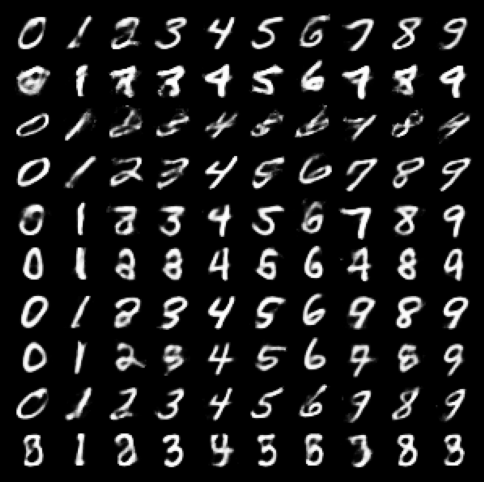

In [287]:
aae.load_weights("experiments/weights/supervised/supervised_15_2000_5.0")
generate_image_grid(aae, latent_dim=LATENT_DIM, name="supervised_15_2000_5", prior_std=5, n_classes=10, n_rows=10)

Weights loaded from experiments/weights/supervised/supervised_15_2000_5.0_*.pth


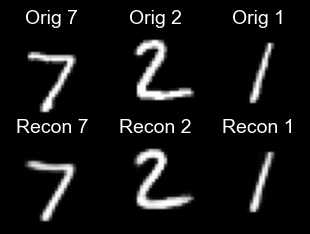

In [381]:
aae.load_weights("experiments/weights/supervised/supervised_15_2000_5.0")
display_reconstructions(aae, name="recon_supervised_15_2000_5", test_loader=test_loader)

## Other experiments

### Prior of 1

Here we set the prior of our assumed Gaussian distribution to 1.

Weights loaded from experiments/weights/supervised/supervised_15_2000_1.0_*.pth


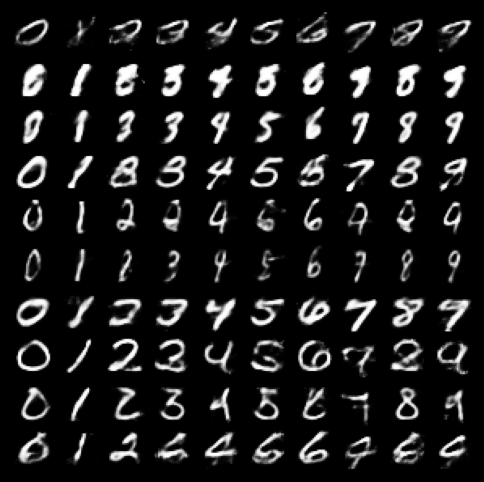

In [ ]:
aae.load_weights("experiments/weights/supervised/supervised_15_2000_1.0")
generate_image_grid(aae, latent_dim=LATENT_DIM, name="supervised_15_2000_1", prior_std=1.0, n_classes=10, n_rows=10)

Weights loaded from experiments/weights/supervised/supervised_15_2000_1.0_*.pth


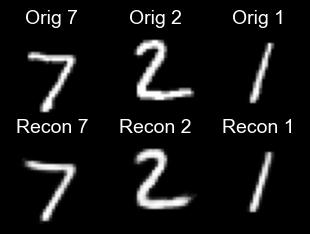

In [382]:
aae.load_weights("experiments/weights/supervised/supervised_15_2000_1.0")
display_reconstructions(aae, name="recon_supervised_15_2000_1", test_loader=test_loader)

### SGD
We explore how SGD performs when prior std is set to 5 vs 1.

Weights loaded from experiments/weights/supervised/supervised_sgd_15_2000_5.0_*.pth


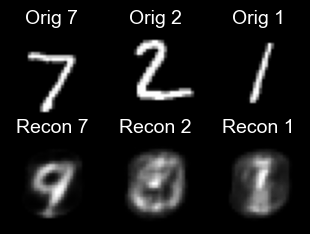

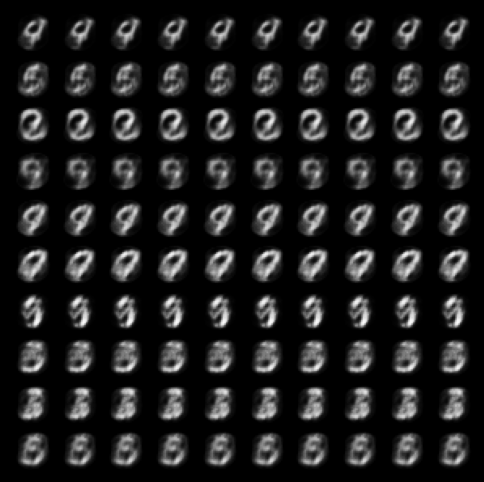

In [385]:
aae.load_weights("experiments/weights/supervised/supervised_sgd_15_2000_5.0")
display_reconstructions(aae, test_loader, name="recon_supervised_sgd_15_2000_5")
generate_image_grid(aae, latent_dim=LATENT_DIM, name="supervised_sgd_15_2000_5", prior_std=5.0, n_classes=10, n_rows=10)

Weights loaded from experiments/weights/supervised/supervised_sgd_15_2000_1.0_*.pth


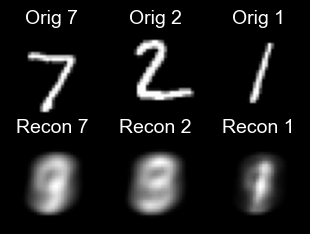

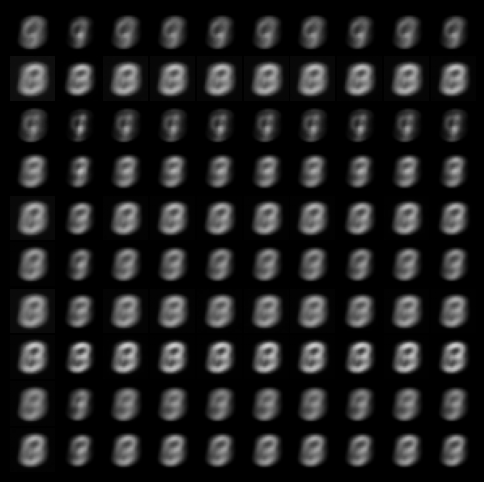

In [386]:
aae.load_weights("experiments/weights/supervised/supervised_sgd_15_2000_1.0")
display_reconstructions(aae, test_loader, name="recon_supervised_sgd_15_2000_1")
generate_image_grid(aae, latent_dim=LATENT_DIM, name="supervised_sgd_15_2000_1", prior_std=1.0, n_classes=10, n_rows=10)

## Learning Curves

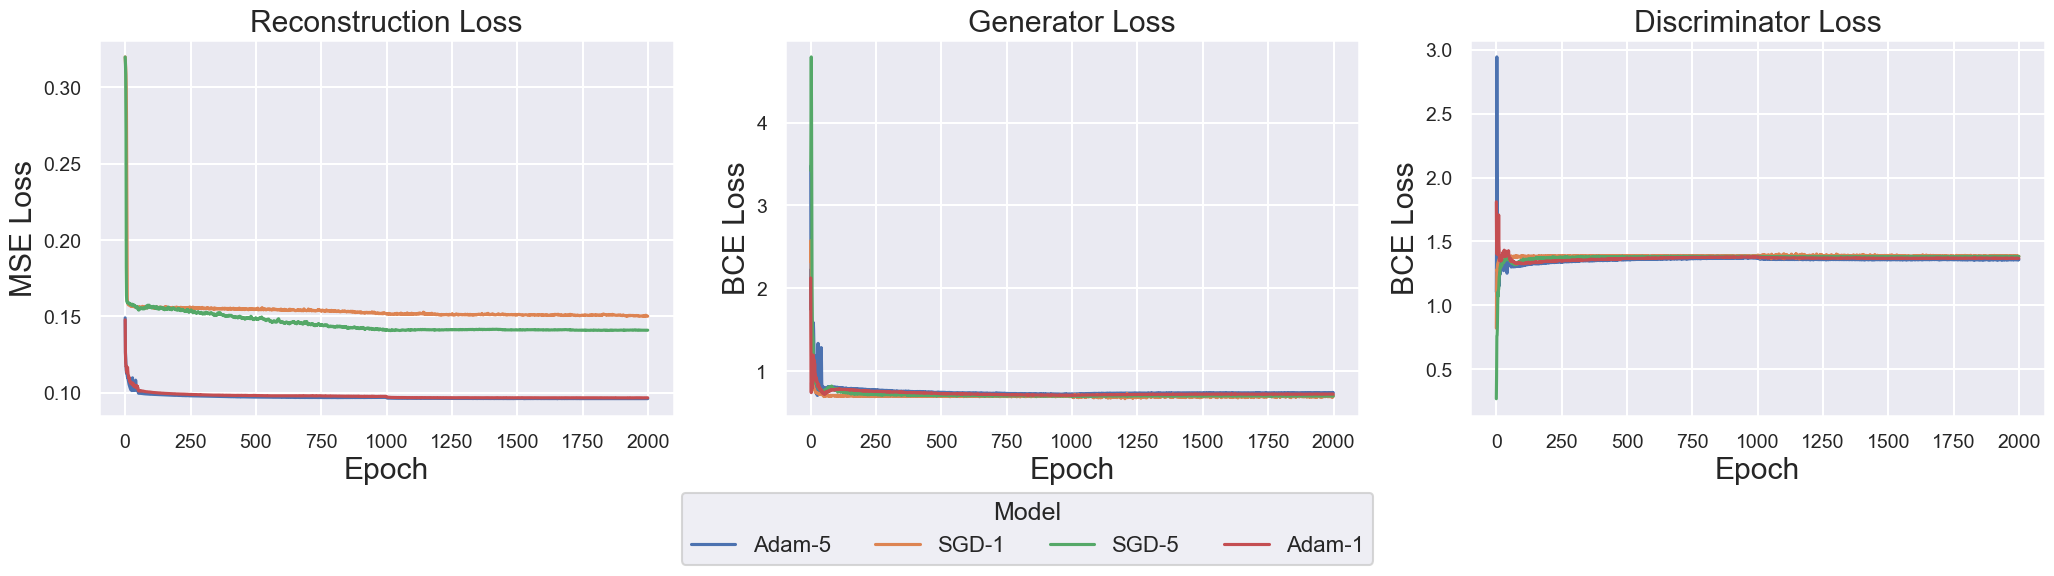

In [343]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_loss_data(csv_file, loss_type, value_name):
    df = pd.read_csv("experiments/logs/supervised/" + csv_file, quotechar='"')
    value_vars = [col for col in df.columns if loss_type in col and '__' not in col]

    df_melted = df.melt(id_vars='Step', value_vars=value_vars,
                        var_name='Model', value_name=value_name)
    
    df_melted['Model'] = df_melted['Model'].str.replace(f' - {loss_type}', '', regex=False)
    
    df_melted['Step'] = pd.to_numeric(df_melted['Step'], errors='coerce')
    
    return df_melted

df_recon = prepare_loss_data('reconstruction_loss_logs.csv', 'recon_loss', 'Reconstruction Loss')
df_gen   = prepare_loss_data('generator_loss_logs.csv', 'gen_loss', 'Generator Loss')
df_disc  = prepare_loss_data('discriminator_loss_logs.csv', 'disc_loss', 'Discriminator Loss')

sns.set_context("talk", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharex=True)

# Plot Reconstruction Loss
sns.lineplot(data=df_recon, x='Step', y='Reconstruction Loss', hue='Model', ax=axes[0])
axes[0].set_title('Reconstruction Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')

# Plot Generator Loss
sns.lineplot(data=df_gen, x='Step', y='Generator Loss', hue='Model', ax=axes[1])
axes[1].set_title('Generator Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BCE Loss')

# Plot Discriminator Loss
sns.lineplot(data=df_disc, x='Step', y='Discriminator Loss', hue='Model', ax=axes[2])
axes[2].set_title('Discriminator Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('BCE Loss')

for ax in axes:
    ax.grid(True)
    ax.tick_params(labelsize=14)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', loc='lower center', ncol=4, fontsize=16, title_fontsize=18)
for ax in axes:
    ax.get_legend().remove()

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("figs/supervised/losses.png", dpi=300, bbox_inches='tight')
plt.show()
